<h1><center>Hamiltonian Neural Network</center></h1>
<h5><center>Ramezan Ebrahimi, Dennis Siebert, Constanze Vogel</center></h5>
<h8><center>Advanced Machine Learning - 2024 </center></h8>

In the following Notebook we discuss an Hamiltonian Neural Network as proposed in the 2019 Paper "Hamiltonian Neural Networks" by Sam Greydanus, Misko Dzamba, Jason Yosinski (https://arxiv.org/abs/1906.01563). The described system of a set of masses connected by strings was modeled after similar examples by the authors found at https://github.com/greydanus/hamiltonian-nn. Since there are some physical intricacies regarding this system such as possible collisions of the masses or between masses and the wall, the used Hamiltonian is not of the correct form. This, however,  does not take away from the validity of the results shown in the following notebook as the effectiveness of the method can be observed even in this simplified case. 

<center><img src="two_mass_system.png"/></center>
<figcaption align = "center"> Figure 1: System of three springs and two masses </figcaption>

The following code illustrates the steps taken to successfully train an Hamiltonian Neural Network able to predict trajectories of two masses in a (simplified) system like shown in Figure 1.

The Hamiltonian Neural Network differs from a regular Neural Network in the way it intrinsically features energy conservation. Its rough scheme is shown in the Figure below:


<center><img src="HNN_baseline_overview.png"/></center>
<figcaption align = "center"> Figure 3: A rough scheme of an commmon NN and the Hamilton NN. Figure taken direcly from the Paper available on arXiv. </figcaption>

The baseline NN predicts the values for $\frac{\partial{q}}{\partial{t}}$ and $\frac{\partial{p}}{\partial{t}}$ following the usual procedure of a Neural Network: The NN is being trained on a set of input data $(q, p)$ and output $(\frac{\partial{q}}{\partial{t}},\frac{\partial{p}}{\partial{t}})$. As shown in Figure 3 the baseline model's prediction deviates from the ground truth quite heavily. The Hamiltonian NN is essentially trained on the same data (in the sense that the Loss is still calculated from true and predicted sets of $(\frac{\partial{q}}{\partial{t}},\frac{\partial{p}}{{\partial{t}}})$, where the predictions are expressed in terms of the Hamiltonian), there is an intermediate step of predicting the Hamiltonian, the actual output of the Neural Network itself. As the derivates of H in respect to its coordinates on phase space, namely $(-\frac{\partial{H}}{\partial{q}},\frac{\partial{H}}{{\partial{p}}})$ are directly linked to the time derivation in the output data by the Hamilton equations, the model is able to learn something about the Hamiltonian itself.

<h5>Step 1: Create the Data used for training and testing<h5>

For creating the data the following libaries were used:

In [2]:
# Import libraries
# We are using autograd library for derivation 
# To install autograd run:
# pip install autograd
# for more information you can check: 
# https://github.com/HIPS/autograd/tree/master

# import libraries
import os, sys
import autograd
import autograd.numpy as np
import torch, time, argparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = 'experiment-3spring'
sys.path.append(EXPERIMENT_DIR)

# Train and Data file without collision
from hnn import HNN
from nn_models import MLP
from train import get_args
from utils import L2_loss, rk4
from data import get_dataset, get_trajectory, dynamics_fn, hamiltonian_fn, potential_energy, kinetic_energy, get_args_ham, get_rand_starting_position


The function defining globally used constants for the system are being set in a function get_args_ham(). 

In [2]:
sys.argv = sys.argv[:1] 
args=get_args()
args_ham=get_args_ham()

In [3]:
args

Namespace(input_dim=4, hidden_dim=150, learn_rate=0.001, batch_size=200, input_noise=0.0, nonlinearity='tanh', total_steps=1000, print_every=200, name='3spring', baseline=False, use_rk4=False, verbose=False, field_type='solenoidal', seed=0, save_dir='/Users/mac/Documents/Codes/Advanced Machine Learning/AdvancedMachineLearningEnv/hamiltonian-nn/Updated Spring Exp/untitled folder/Hamiltonian-Neural-Network-The-most-stupid-branch/Hamiltonian-Neural-Network-The-most-stupid-branch/experiment-3spring', feature=True)

The Hamiltonian consists of a potential and kinetic energy of the following form:
$$E_{pot}=\frac{1}{2}*k_1*(q_1-L_1)^2+\frac{1}{2}*k_2*((q_2-q_1)-L_2)^2+\frac{1}{2}*k_3*(q_2-(L_1+L_2))^2$$
$$E_{kin}=\frac{p_1^2}{2m_1}+\frac{p_2^2}{2m_2}$$
$$H=T+V$$

In [6]:
def potential_energy(q, args):
    '''U=0.5 * k1 * (q1 - L1)^2 + 0.5 * k2 * (q2 - q1 - L1)^2 + 0.5 * k3 * (q2-L1-L2)^2'''
    # Potential Energy
    
    k=[args['k1'],args['k2'],args['k3']]
    L_list=[args['l1'], args['l2'], args['l3']]

    try:
        if q.shape[1]>1:
            # Convert the list to a numpy array and tile it to have 100 rows

            L= np.tile(L_list, (q.shape[0], 1))
            U = 0.5 * k[0] * (q[:,0].T - L[:,0].T)**2 + 0.5 * k[1] * (q[:,1].T - q[:,0] - L[:,1].T)**2 + 0.5*k[2]*(q[:,1].T-L[:,0].T-L[:,1].T)**2
    except:
        U = 0.5 * k[0] * (q[0] - L_list[0])**2 + 0.5 * k[1] * (q[1] - q[0] - L_list[1])**2 + 0.5*k[2]*(q[1]-L_list[0]-L_list[1])**2 # potential energy
    return U

def kinetic_energy(p, args=get_args_ham()):
    '''T=sum_i 0.5*m_i*v^2'''
    # Kinetic Energy
    m=[args['m1'], args['m2']]
    
    try:

        if p.shape[1]>1:
            T = p[:,0].T**2/(2*m[0]) + p[:,1].T**2/(2*m[1])
    except:
        T = p[0]**2 / (2 * m[0]) + p[1]**2 / (2 * m[1])  # kinetic energy
    return T

def hamiltonian_fn(q, p, args=get_args_ham()):

    T = kinetic_energy(p,args)  # kinetic energy
    V = potential_energy(q,args) # potential energy
    H = T + V
    return H

As the derivatives of the Hamiltonian are also needed, we need a function calcuating these. Here the torch function autograd calculates the gradient with respect to the 0th ($q$ or $(q_1,q_2)$) and 1st ($p$ or $(p_1,p_2)$) input respectively. 

In [7]:
def dynamics_fn(t, coords):
    q, p = coords[:2], coords[2:]
    dH_dq = autograd.grad(hamiltonian_fn, 0)
    dH_dp = autograd.grad(hamiltonian_fn, 1)
    dqdt = np.array([dH_dp(q, p)[i] / m for i, m in enumerate([1.0, 1.0])]) #ASK RAMSI
    dpdt = -np.array([dH_dq(q, p)[i] for i in range(2)])
    return np.concatenate((dqdt, dpdt))

In order to match a tuple of coordinates $((q_1,q_2),(p_1,p_2))$ we need the time evolution of the system, which is given by the funtion get_trajectory

In [8]:
def get_trajectory(t_span=[0,10], timescale=10, radius=None, y0=None, noise_std=0.0, update_fn=dynamics_fn, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0]))) 
    y0 = np.asarray(y0).flatten()
    spring_ivp = solve_ivp(fun=update_fn, t_span=t_span, y0=y0.flatten(), t_eval=t_eval, rtol=1e-10, **kwargs)
    q1, q2, p1, p2 = spring_ivp['y'][0], spring_ivp['y'][1], spring_ivp['y'][2], spring_ivp['y'][3]
    #print("q1 shape", np.array(q1).shape)

    
    # Change row vector to column vector
    q1, q2 = np.atleast_2d(q1).T, np.atleast_2d(q2).T
    p1, p2 = np.atleast_2d(p1).T, np.atleast_2d(p2).T
    q, p = np.concatenate((q1, q2), axis=1), np.concatenate((p1, p2), axis=1)
    dydt = np.array([dynamics_fn(None, y) for y in spring_ivp['y'].T])
    dqdt, dpdt = np.split(dydt, 2, axis=1)

    settings = locals()
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval, settings

t_eval gives all the timepoints on which we will evaluate $(q,p)$ as well as $(\frac{\partial{q}}{\partial{t}},\frac{\partial{p}}{\partial{t}})$. As the problem of the trajectory is essentially an initial value problem we set $y_0$ to be the inital value for $(q_1,q_2,p_1,p_2)$. The solve_ivp function of the scipy library solves this for us. Its outputs are tuples of $(q_1, q_2, p_1, p_2)$. The derivatives at all times $t$ (meaning all positions given by solve_ivp) are computed with the dynamics_fn function mentioned above. Finally the funtion get_trajectory returns arrays of values $q=(q_1,q_2)$,$ p=(p_1,p_2)$, $\frac{\partial{q}}{\partial{t}}=(\frac{\partial{q_1}}{\partial{t}},\frac{\partial{q_2}}{\partial{t}})$ and $\frac{\partial{p}}{\partial{t}}=(\frac{\partial{p_1}}{\partial{t}},\frac{\partial{p_2}}{\partial{t}})$ for all times in the t_eval array. 

In [9]:
def get_rand_starting_position():
    #returns random starting position vector. p's are 0 by default.
    #respects physical condition for q's: q1 < q2
    args = get_args_ham()
    L=args['l1'] + args['l2'] + args['l3']
    
    q0 = np.random.uniform(0,L,2)
    while q0[0] > q0[1]:
        q0 = np.random.uniform(0,L,2)
    
    #p0 = np.array([0, 0])
    p0 = np.random.uniform(-0.9, 0.9, 2)
    y0 = np.concatenate([q0, p0])
    
    return y0

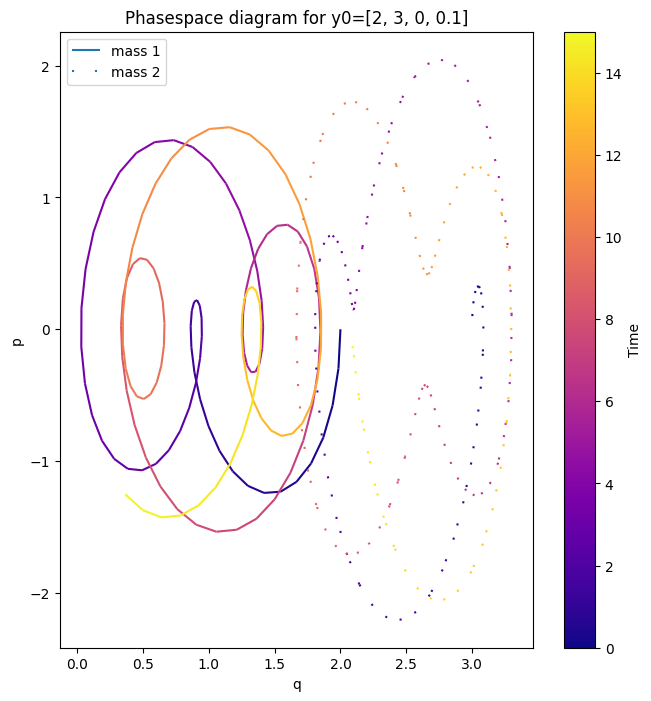

In [4]:
y0_demo=[2,3,0,0.1]
q_demo, p_demo, dqdt_demo, dpdt_demo, t_eval_demo, settings_demo=get_trajectory(t_span=[0,15], timescale=10, radius=None, y0=y0_demo, noise_std=0.0, update_fn=dynamics_fn)

# Create the plot
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Prepare the line segments
points1 = np.array([q_demo[:, 0], p_demo[:,0]]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)

points2 = np.array([q_demo[:, 1], p_demo[:,1]]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)


# Create a LineCollection
lc = LineCollection(segments1, cmap='plasma', norm=plt.Normalize(t_eval_demo.min(), t_eval_demo.max()),linestyle='solid',label='mass 1')
lc.set_array(t_eval_demo)
ax.add_collection(lc)

lc2 = LineCollection(segments2, cmap='plasma', norm=plt.Normalize(t_eval_demo.min(), t_eval_demo.max()),linestyle=(0,(1,10)),label='mass 2')
lc2.set_array(t_eval_demo)
ax.add_collection(lc2)

ax.autoscale()
ax.set_aspect('equal')
ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_title('Phasespace diagram for y0={}'.format(y0_demo))
ax.legend(loc=2)

# Add color bar to represent the time (or t_eval_demo)
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Time')

plt.show()

The plot above shows the trajectories for masses with the initial parameters $y_0$. Setting the intial state to be $y_0=[L_1,L_2,0,0]$ will result in the masses not moving as the system is already in equilibrium (no trajectories will be shown in the plot above). In reality the system should relax into this state after a sufficiently large time period due to friction. Another problem we encountered was that depending on the chosen inital state and in particular on the momenta the mass might brake through the boundaries of the system and end up at a place $q<0$ or the masses might colide. Solving this issues entirely would go beyond the scope of this project. We did introduce the possibilitiy of a collision but even then the efficiency is very dependent on set parameters as new challenges and problems came up. Thus the system allows only for the calculations with small pertubations.

Once there is a way to obtain the time evolution of the inital position, creating the dataset is pretty straightforward. The function get_dataset() in the data.py file creates a set of 50 sample trajectories. These are then splitted into a train and test set by a ratio of 0.5. 

<h5>Step 2: Defining the used models <h5>

For the Neural Network we choose the following architecture: As the input consists of a set $(q_1, q_2, p_1, p_2)$ the input_dimension is set to be 4. Each hidden layer has 200 neurons as the activation function we will use the tanh function.

In [12]:
def get_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2*2, type=int, help='dimensionality of input tensor') # will be 2*2 for q1,q2,p1,p2
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=200, type=int, help='batch_size')
    parser.add_argument('--input_noise', default=0.0, type=float, help='std of noise added to inputs')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=10000, type=int, help='number of gradient steps')
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--name', default='3spring', type=str, help='only one option right now')
    parser.add_argument('--baseline', dest='baseline', action='store_true', help='run baseline or experiment?')
    parser.add_argument('--use_rk4', dest='use_rk4', action='store_true', help='integrate derivative with RK4')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=THIS_DIR, type=str, help='where to save the trained model')
    parser.set_defaults(feature=True)
    return parser.parse_args()


The models will be built by the classes MLP and HNN.

The MLP class it pretty straight forward. The constructor sets a model with 4 layers: 1 input layer, 2 hidden layers and 1 output layer. The foward function of the class simply passes the input through the layers and passes it though the activation function (except for the output layer).

In [12]:
class MLP(torch.nn.Module):
  '''Just a salt-of-the-earth MLP'''
  def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity='tanh'):
    super(MLP, self).__init__()
    self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
    self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear4 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

    for l in [self.linear1, self.linear2, self.linear3, self.linear4]:
      torch.nn.init.orthogonal_(l.weight) # use a principled initialization

    self.nonlinearity = choose_nonlinearity(nonlinearity)

  def forward(self, x, separate_fields=False):
    h = self.nonlinearity( self.linear1(x) )
    h = self.nonlinearity( self.linear2(h) )
    h = self.nonlinearity( self.linear3(h) )
    return self.linear4(h)

For it to be a Hamiltonian Neural Network a few more steps are needed. Since we are dealing with a vector-valued field H in phase-space (a solenoidal field) the values of $\frac{dH}{dq}$ and $\frac{dH}{dp}$ will be calculated using the rotor of the field. This is comparable to the B Field being $B=\nabla\times A$. Since the rotation is defined by $(\nabla\times H)_i=\epsilon_{ijk}\partial_j H_k$ we define the Levi-Civita permutation tensor in the permutation tensor function below. The foward function acts different depending on wether the baseline model or the HNN model is being used. For the baseline model it simply returns the computed output of the NN $(\dot{q}, \dot{p})$ while for the HNN the output of the Neural Network $H$ is further used to calculate its derivatives (with the autograd.grad function). In this sense time_derivative() refers to the temporal derivates of $q$ and $p$ as these are directly linked to the computed "spatial" derivatives of $H$ via the Hamilton equations.

In [13]:
class HNN(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.field_type = field_type
    
    def forward(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x) # 
    
        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)
    
    def rk4_time_derivative(self, x, dt): # rungekuta
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)
    
    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)
    
        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass
    
        conservative_field = torch.zeros_like(x) # start out with both components set to 0
        solenoidal_field = torch.zeros_like(x)
    
        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            conservative_field = dF1 @ torch.eye(*self.M.shape)
    
        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            solenoidal_field = dF2 @ self.M.t()
    
        if separate_fields:
            return [conservative_field, solenoidal_field]
        
        return conservative_field + solenoidal_field
    
    def permutation_tensor(self,n):
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            '''Constructs the Levi-Civita permutation tensor'''
            M = torch.ones(n,n) # matrix of ones
            M *= 1 - torch.eye(n) # clear diagonals
            M[::2] *= -1 # pattern of signs
            M[:,::2] *= -1
    
            for i in range(n): # make asymmetric
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M


<h5>Step 3: Training the model<h5>

In order to train the model one need to execute the train.py file (done further down below). First all necessary models are constructed. For the updating rule for the weight we use the Adam algorithm, which is a combination of RMSProp and the use of momenta. The generated data x is rought into its tensor form, usable by the defined networks.  Training starts by putting some noise on the data and passing it trough the network (this happens in the time_derivative() function). For the baseline model the output of the network $(\dot{q},\dot{p})$ is directly compared to the labels and used to calculate the loss. For the HNN network the output of the model $(H)$ is used to calculate its derivates and only then used in the loss function. In the HNN this loss is defined by $$L_{HNN}=||\frac{\partial{H}}{\partial{p}}-\frac{\partial{q}}{\partial{t}}||_2 + ||\frac{\partial{H}}{\partial{q}}+\frac{\partial{p}}{\partial{t}}||_2.$$ The gradient of the loss (computed by torch.Tensor.backward()) The model then uses backpropagation to update the weights accordingly. After that we do one optimization step, the grad. field of the weights is then being reset to zero. After this step the test error is also being computed.

In [14]:
def train(args):

    # init model and optimizer
    if args.verbose:
        print("Training baseline model:" if args.baseline else "Training HNN model:")
    
    output_dim=args.input_dim if args.baseline else 2 # will be 2*4 for q1,q2,p1,p2
    nn_model=MLP(args.input_dim,args.hidden_dim, output_dim,args.nonlinearity) # construct NN class object
    model=HNN(args.input_dim,differentiable_model=nn_model,field_type=args.field_type,baseline=args.baseline) #construct HNN class object
    optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-4) #ADAM
    

    #arrange data into tet data
    data=get_dataset(args.seed, noise_std=args.input_noise)
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    print(x.size())
    test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    test_dxdt = torch.Tensor(data['test_dcoords'])
    
    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []} #statistics we need
    for step in range(args.total_steps+1): #how many training steps we wasnt to take
        # train step
        ixs = torch.randperm(x.shape[0])[:args.batch_size] # randomly premuted indices of x
        dxdt_hat = model.time_derivative(x[ixs]) # from hnn model, time derivative of randomly chosen points
        dxdt_hat += args.input_noise * torch.randn(*x[ixs].shape) # add noise, maybe
        loss = L2_loss(dxdt[ixs], dxdt_hat) # squared loss of this batch
        loss.backward() #calculate gradients
        grad = torch.cat([p.grad.flatten() for p in model.parameters()]).clone() # concatenates the tensors, flattens grad. field of weights
        optim.step() ; optim.zero_grad() #one optimization step

        # run test data
        test_ixs = torch.randperm(test_x.shape[0])[:args.batch_size]
        test_dxdt_hat = model.time_derivative(test_x[test_ixs])
        test_dxdt_hat += args.input_noise * torch.randn(*test_x[test_ixs].shape) # add noise, maybe
        test_loss = L2_loss(test_dxdt[test_ixs], test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if args.verbose and step % args.print_every == 0:
          print("step {}, train_loss {:.4e}, test_loss {:.4e}, grad norm {:.4e}, grad std {:.4e}"
              .format(step, loss.item(), test_loss.item(), grad@grad, grad.std()))

    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat)**2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat)**2
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
    .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))


    return model, stats

The following commands start the training process for both the HNN and baseline models. At first we train the networks on trajectories with no noise added. The train function will generate a dataset of 50 trajectories and train for a default value of 1000 epochs.

In [5]:
!python ./experiment-3spring/train.py --baseline --input_noise=0 --verbose
!python ./experiment-3spring/train.py --input_noise=0 --verbose

Training baseline model:
step 0, train_loss 7.8263e+00, test_loss 1.1653e+01, grad norm 1.7726e+01, grad std 2.7177e-02
step 200, train_loss 1.2160e-01, test_loss 2.6546e-01, grad norm 3.4337e-01, grad std 3.7825e-03
step 400, train_loss 2.5707e-02, test_loss 1.4760e-01, grad norm 1.5433e-01, grad std 2.5359e-03
step 600, train_loss 7.3949e-03, test_loss 2.8962e-02, grad norm 2.5010e-01, grad std 3.2282e-03
step 800, train_loss 2.6492e-03, test_loss 3.0484e-02, grad norm 2.0014e-01, grad std 2.8878e-03
step 1000, train_loss 1.7021e-03, test_loss 1.6010e-02, grad norm 2.8465e-02, grad std 1.0890e-03
Final train loss 1.9599e-03 +/- 3.2218e-04
Final test loss 1.3033e-02 +/- 2.3280e-03
Training HNN model:
step 0, train_loss 1.8960e+01, test_loss 1.3666e+01, grad norm 1.0045e+00, grad std 6.5105e-03
step 200, train_loss 7.8258e-01, test_loss 5.0056e-01, grad norm 1.9594e+00, grad std 9.0928e-03
step 400, train_loss 1.3964e-01, test_loss 1.3714e-01, grad norm 2.5649e-01, grad std 3.2898e-03


<h3>Results<h3>

In [6]:
def load_model(args,baseline=None):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/{}-{}.tar".format(args.save_dir, args.name, model_name)
    model.load_state_dict(torch.load(path))
    return model

base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

In [7]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, coords, model):

    # Reshape coords to (1, 4)
    np_x = np.copy(coords).reshape(1,4)
    
    # Convert numpy array to torch tensor
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    
    # Compute the time derivative using the model
    dx_hat = model.time_derivative(x)
    
    # Detach the result and convert it to a numpy array
    deriv = dx_hat.detach().data.numpy().T
    
    return deriv.flatten()

Now we want to evaluate the performance of both models. To this end we use both models to generate trajectories using the same initial values and time span.

In [8]:
# Variables used in plots
#######################
lw = 3 # linewidth
fs=9 # legend font size 
ts=15 # title font size
tpad = 7 # title padding
ls=12 # label font size
colors = ['orangered', 'purple' ,'orange', 'mediumpurple']
#######################

t_points = 50
t_span = [0,200]
fig_size = [15,4]
y0 = get_rand_starting_position()

print(y0)
q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

[ 2.9918815   4.66262268 -0.52776862 -0.67163616]


/Users/mac/Documents/Codes/Advanced Machine Learning/AdvancedMachineLearningEnv/lib/python3.9/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `t_points`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


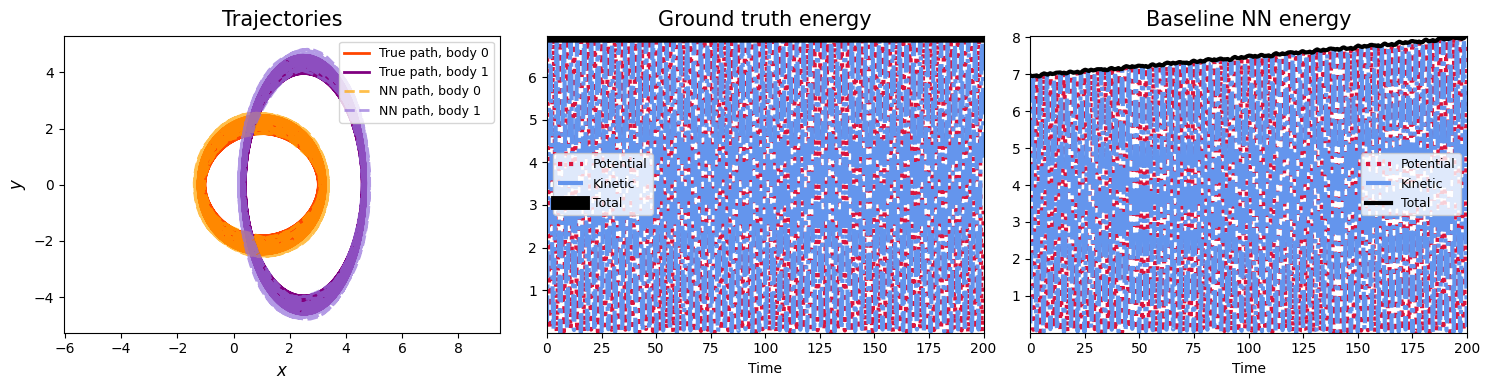

In [9]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t, base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()
# fig.savefig('{}/orbits-base-example.{}'.format(args.fig_dir, FORMAT))

<h5>HNN model<h5>

In [10]:
#uncomment below line to generate new random start position. Default: use same start point as baseline model above
#y0 = get_rand_starting_position()
print(y0)
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

[ 2.9918815   4.66262268 -0.52776862 -0.67163616]


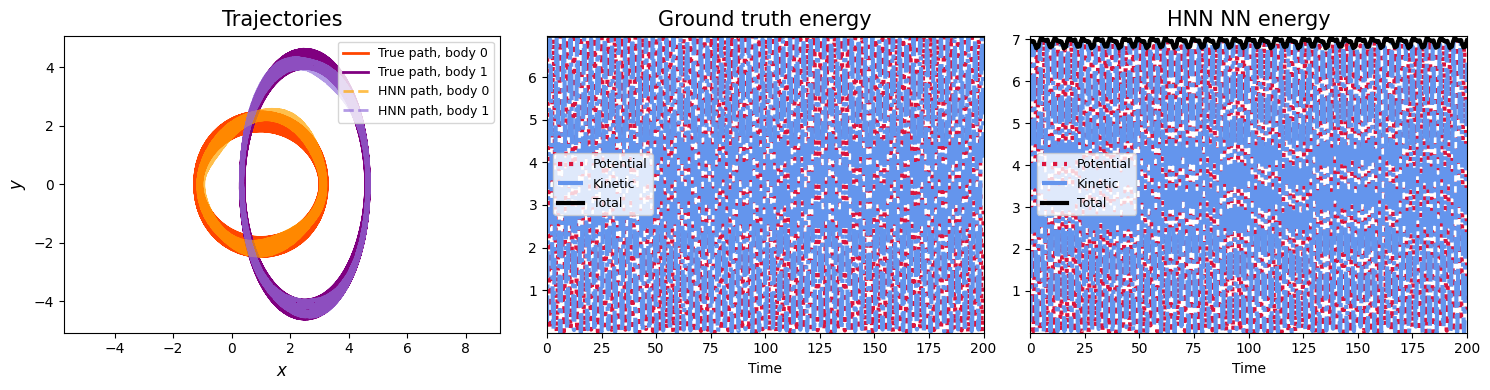

In [11]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7, label='HNN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, hnn_pe, ':', color='crimson',  label='Potential', linewidth=lw)
plt.plot(t, hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, hnn_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()

With increasing time, it is evident that the HNN model performs better both in inferring the correct trajectories and respecting energy conservation. While it does show fluctuations, the baseline model's predicted total energy deviates strongly after some time.

<h5>Quantitative Analysis<h5>

When looking at the mean squared error of energy of the baseline model and the HNN, one can see a clear difference in the size of the error especially with increasing time. The baseline model's prediction deviates from the ground truth quickly and does not recover. The HNN's prediciton does also deviate from the ground truth but at a much slower rate that the Baseline models.

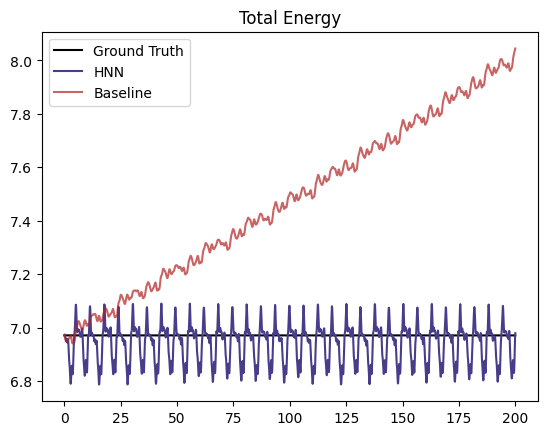

In [12]:
#Energy plot
plt.plot(t, real_etot,'-k', label='Ground Truth')
plt.plot(t, hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t, base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

In general, for the zero noise case the HNN and baseline models show similar performance in many cases. It is noticeable however that the baseline model fails to respect energy conservation.

The below plot shows the ground truth of the trajectory of the center of mass. In phase-space the trajectory should be closed as energy conservation is in effect. Furthermore for an harmonic oscillation (for the simplest case this can be achieved by setting the same masses, the same spring constants and the same inital displacement from the rest length of the springs) the trajectory should be an ellipse. The below plot will thus be more expressing when setting this conditions in the data file, as the deviation from the trajectory of the ground truth is visible more cleary.

In [13]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])


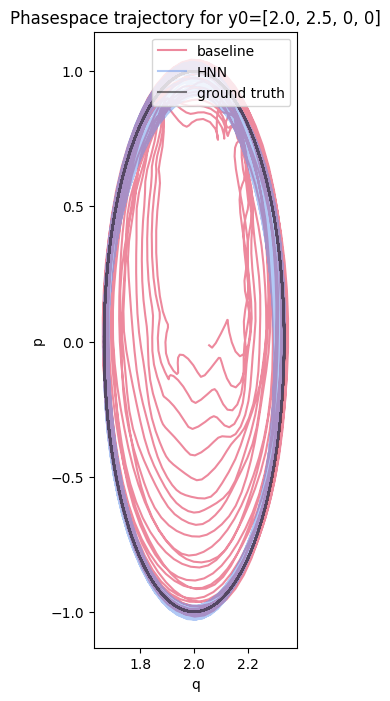

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=[6,8])

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend(loc="upper right")

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))


plt.show()

## Train with Noise 0.05

In order to test the stability of both methods with respect to noise, we first retrain the models adding a small amount of noise to the training samples.

In [15]:
!python ./experiment-3spring/train.py --baseline --input_noise=0.05 --verbose
!python ./experiment-3spring/train.py --input_noise=0.05 --verbose

Training baseline model:
step 0, train_loss 1.2410e+01, test_loss 1.1594e+01, grad norm 3.0301e+01, grad std 3.5533e-02
step 200, train_loss 2.5863e-01, test_loss 3.0167e-01, grad norm 1.2938e+00, grad std 7.3423e-03
step 400, train_loss 1.4214e-01, test_loss 1.6924e-01, grad norm 7.3656e+00, grad std 1.7519e-02
step 600, train_loss 7.8463e-02, test_loss 8.8137e-02, grad norm 2.5605e-01, grad std 3.2663e-03
step 800, train_loss 7.1974e-02, test_loss 6.8850e-02, grad norm 9.2300e-01, grad std 6.2016e-03
step 1000, train_loss 6.8545e-02, test_loss 6.9080e-02, grad norm 6.6566e-01, grad std 5.2666e-03
Final train loss 6.2752e-02 +/- 2.7734e-03
Final test loss 6.9025e-02 +/- 3.3625e-03
Training HNN model:
step 0, train_loss 1.3004e+01, test_loss 7.9945e+00, grad norm 7.5423e-01, grad std 5.6414e-03
step 200, train_loss 4.3386e-01, test_loss 2.9048e-01, grad norm 1.8390e+00, grad std 8.8089e-03
step 400, train_loss 1.4684e-01, test_loss 1.1960e-01, grad norm 5.5452e-01, grad std 4.8372e-03


Now let's load the model trained with noise and inspect their performance. The initial values and evaluation time span have stayed the same.

In [16]:
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

In [17]:
y0 = get_rand_starting_position()
q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

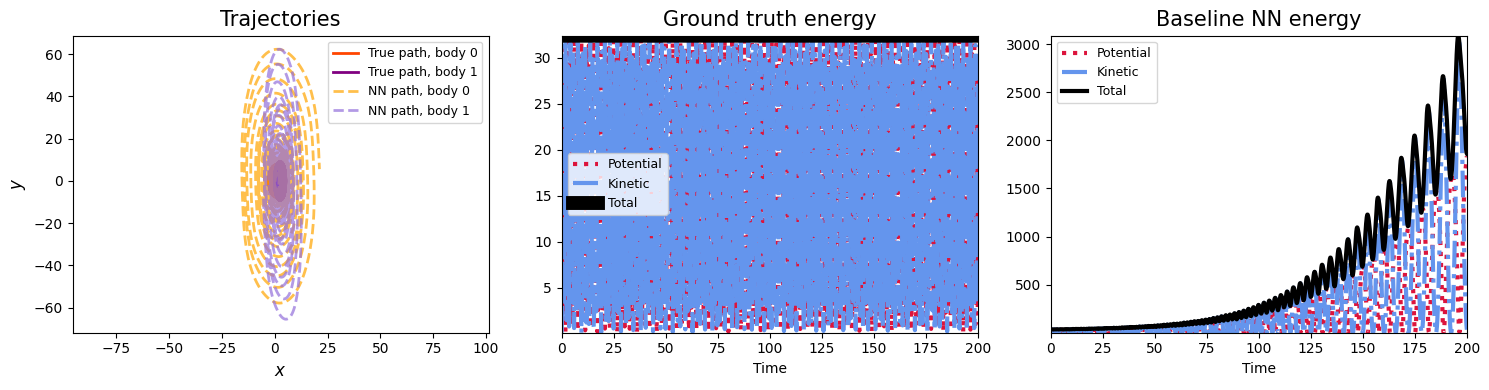

In [18]:
fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t, base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()

In [19]:
# using the same y0 as baseline model
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

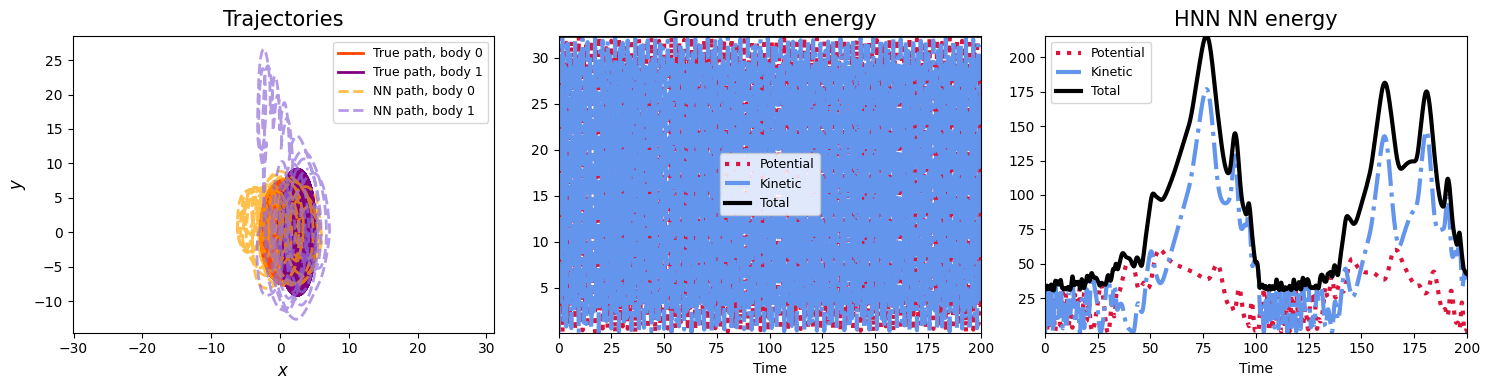

In [20]:
fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7, label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, hnn_pe, ':', color='crimson',  label='Potential', linewidth=lw)
plt.plot(t, hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, hnn_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()

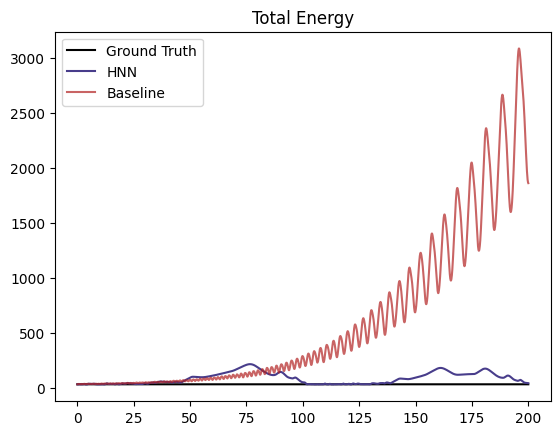

In [21]:
#Energy plot
plt.plot(t, real_etot,'-k', label='Ground Truth')
plt.plot(t, hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t, base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

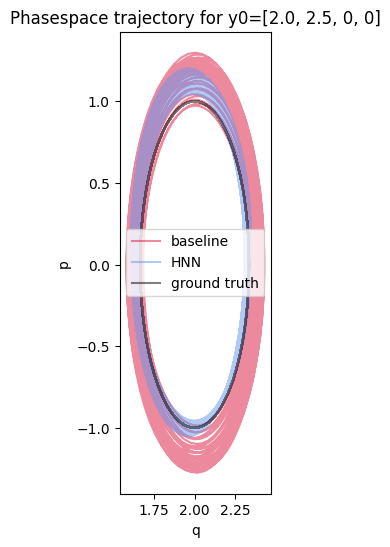

In [22]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))
plt.show()

## Train with noise 0.1

Now we double the noise level:

In [23]:
!python ./experiment-3spring/train.py --baseline --input_noise=0.1 --verbose
!python ./experiment-3spring/train.py --input_noise=0.1 --verbose

base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

Training baseline model:
step 0, train_loss 1.4713e+01, test_loss 1.2637e+01, grad norm 3.0169e+01, grad std 3.5454e-02
step 200, train_loss 4.7568e-01, test_loss 4.6143e-01, grad norm 3.1859e+00, grad std 1.1522e-02
step 400, train_loss 2.5851e-01, test_loss 2.4309e-01, grad norm 1.7497e+00, grad std 8.5385e-03
step 600, train_loss 2.5369e-01, test_loss 2.0065e-01, grad norm 3.9668e+00, grad std 1.2856e-02
step 800, train_loss 2.6925e-01, test_loss 2.9064e-01, grad norm 4.9892e+00, grad std 1.4418e-02
step 1000, train_loss 2.3758e-01, test_loss 2.4888e-01, grad norm 1.5985e+00, grad std 8.1612e-03
Final train loss 2.3332e-01 +/- 1.0082e-02
Final test loss 2.3472e-01 +/- 1.0423e-02
Training HNN model:
step 0, train_loss 8.9092e+00, test_loss 1.1580e+01, grad norm 2.7261e-01, grad std 3.3914e-03
step 200, train_loss 5.8867e-01, test_loss 1.0923e+00, grad norm 1.6162e+00, grad std 8.2582e-03
step 400, train_loss 2.9642e-01, test_loss 4.9546e-01, grad norm 1.3895e+00, grad std 7.6568e-03


In [24]:
y0 = get_rand_starting_position()
q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

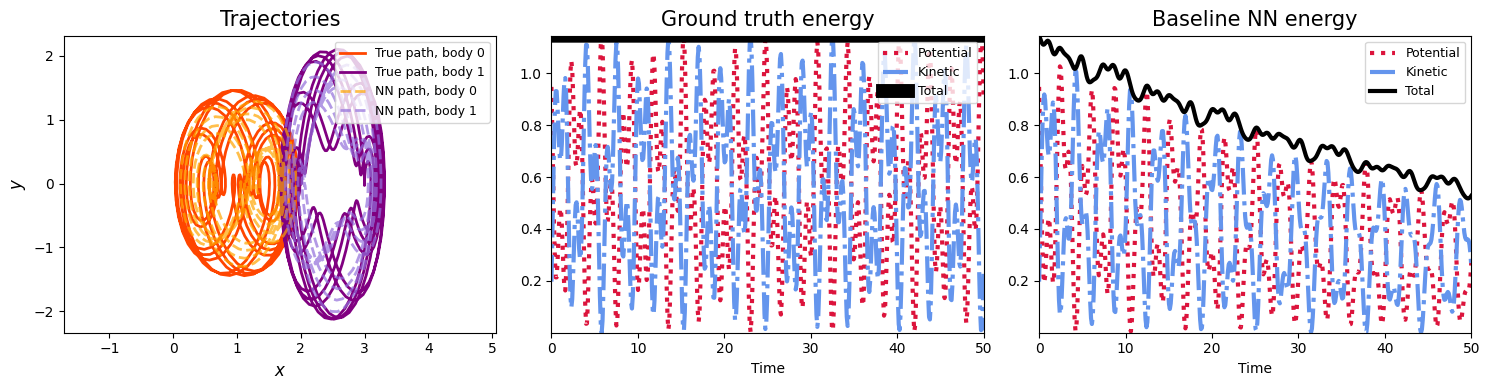

In [25]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t, base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()

In [26]:
# Using the same y0 as baseline
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

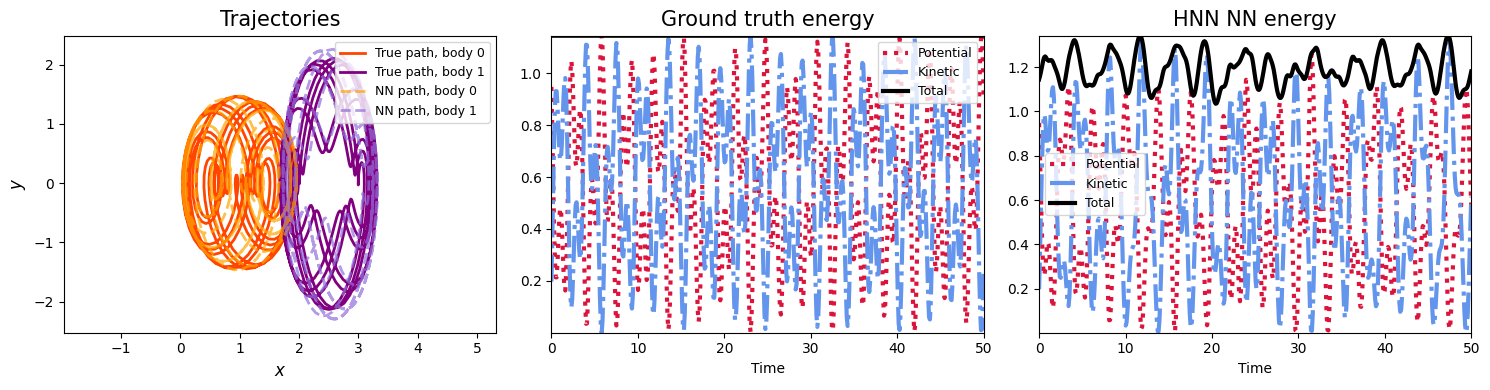

In [27]:
fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7, label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t, real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, real_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t, hnn_pe, ':', color='crimson',  label='Potential', linewidth=lw)
plt.plot(t, hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t, hnn_etot, 'k-', label='Total', linewidth=3)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()

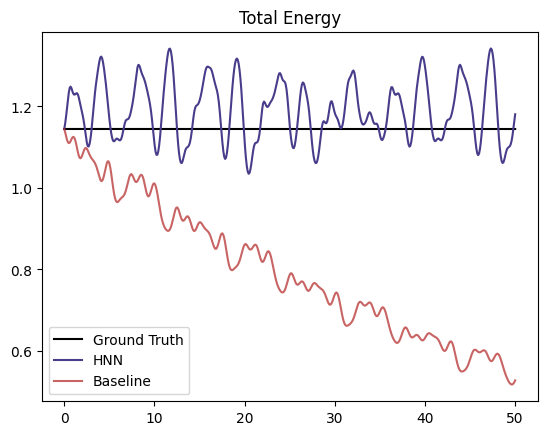

In [28]:
#Energy plot
plt.plot(t, real_etot,'-k', label='Ground Truth')
plt.plot(t, hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t, base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

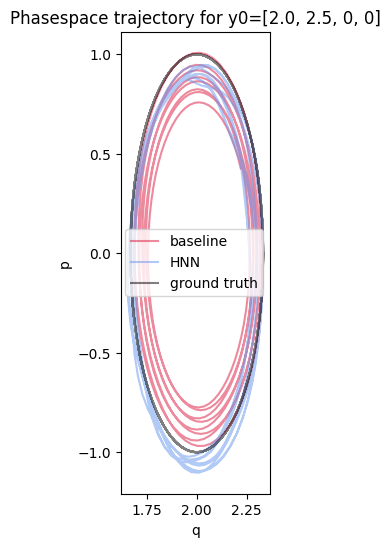

In [29]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))
#ax1.set_xlim(0,args_ham['l1']+args_ham['l2']+args_ham['l3'])


plt.show()

It is noticible that at this point also the hnn is visibly deviating from the ground truth. The most notable difference is still apparent when looking at the energy of the system. Here the HNN still is doing a very good job at recovering from far deviations of the constant energy of the system. 

# Now let's add collision

## Note: You need to restart the kernel in jupyter notebook and run this part of the code

The main purpose of HNNs is to train a neural network with better physics priors. But we can also apply it on systems that we add energy to it or remove energy from it. In the following example we train HNN on a physical system that can understand the collision between two masses. The method that we use in this case is: 
if two masses get closer to each other less than a certain distance(by default it is 0.05) then depending on the fact that position of which mass is bigger the positions will be updated. If q1 > q2 then we reduce the position of mass one with 0.05 and if q2 > q1 we add 0.05 to the position of second mass. With this method we are reducing the potential energy which means the energy for some parts of time is not conserved until we reach to an equilibrium state. we will check how HNN perform on such example with different noise. But before that we will train the model on a physical system that can detect the collision between masses.

In [3]:
# import libraries
import os, sys
import autograd
import autograd.numpy as np
import torch, time, argparse
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.collections import LineCollection
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = 'experiment-3spring'
sys.path.append(EXPERIMENT_DIR)

# Train and Data file without collision
from hnn import HNN
from nn_models import MLP
from utils import L2_loss, rk4


# Train and Data file with collision
from train_collision import get_args
from data_collision import get_dataset, get_trajectory, dynamics_fn, hamiltonian_fn, potential_energy, kinetic_energy, get_args_ham, get_rand_starting_position


In [4]:
sys.argv = sys.argv[:1] 
args=get_args()
args_ham=get_args_ham()

In [7]:
# Setting parameters
m1, m2 = args_ham['m1'], args_ham['m2']
l1, l2, l3 = args_ham['l1'], args_ham['l2'], args_ham['l3']
# Variables used in plots
#######################
lw = 3 # linewidth
fs=9 # legend font size 
ts=15 # title font size
tpad = 7 # title padding
ls=12 # label font size
colors = ['orangered', 'purple' ,'orange', 'mediumpurple']
#######################

t_points = 50
t_span = [0,200]
fig_size = [15,4]

y0_demo = get_rand_starting_position()
q_demo, p_demo, dq_demo, dp_demo, t_demo, settings_demo = get_trajectory(radius=0.7, t_span=t_span, y0=y0_demo, noise_std = 0.0, m = [m1, m2])

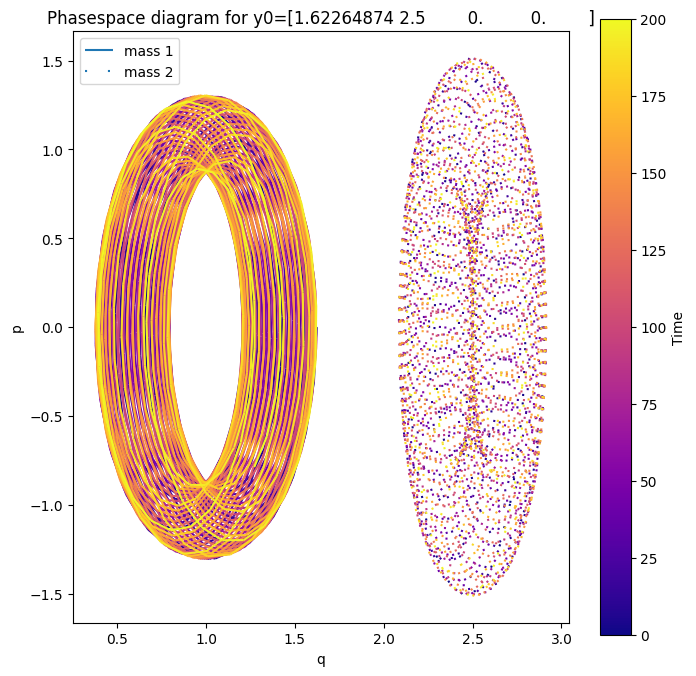

In [10]:
# plot config
# draw trajectories
# Create the plot
fig, ax = plt.subplots(1,1, figsize=(8,8))

# Prepare the line segments
points1 = np.array([q_demo[:, 0], p_demo[:,0]]).T.reshape(-1, 1, 2)
segments1 = np.concatenate([points1[:-1], points1[1:]], axis=1)

points2 = np.array([q_demo[:, 1], p_demo[:,1]]).T.reshape(-1, 1, 2)
segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)


# Create a LineCollection
lc = LineCollection(segments1, cmap='plasma', norm=plt.Normalize(t_demo.min(), t_demo.max()),linestyle='solid',label='mass 1')
lc.set_array(t_demo)
ax.add_collection(lc)

lc2 = LineCollection(segments2, cmap='plasma', norm=plt.Normalize(t_demo.min(), t_demo.max()),linestyle=(0,(1,10)),label='mass 2')
lc2.set_array(t_demo)
ax.add_collection(lc2)

ax.autoscale()
ax.set_aspect('equal')
ax.set_xlabel('q')
ax.set_ylabel('p')
ax.set_title('Phasespace diagram for y0={}'.format(y0_demo))
ax.legend(loc=2)

# Add color bar to represent the time (or t_eval_demo)
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Time')

plt.show()


In [11]:
def load_model(args,baseline=None):
    output_dim = args.input_dim if baseline else 2
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    model = HNN(args.input_dim, differentiable_model=nn_model,field_type=args.field_type, baseline=baseline)
    
    model_name = 'baseline' if baseline else 'hnn'
    path = "{}/{}-{}.tar".format(args.save_dir, args.name, model_name)
    model.load_state_dict(torch.load(path))
    return model

base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)

In [12]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, coords, model):

    # Reshape coords to (1, 4)
    np_x = np.copy(coords).reshape(1,4)
    
    # Convert numpy array to torch tensor
    x = torch.tensor(np_x, requires_grad=True, dtype=torch.float32)
    
    # Compute the time derivative using the model
    dx_hat = model.time_derivative(x)
    
    # Detach the result and convert it to a numpy array
    deriv = dx_hat.detach().data.numpy().T
    
    return deriv.flatten()



## Train Without Noise

In [13]:
!python experiment-3spring/train_collision.py --verbose --input_noise=0.0 
!python experiment-3spring/train_collision.py --baseline --verbose --input_noise=0.0

Training HNN model:
step 0, train_loss 1.4666e+00, test_loss 3.9435e+00, grad norm 2.3510e-02, grad std 7.5176e-04
step 200, train_loss 1.7116e-02, test_loss 5.2689e-02, grad norm 1.3598e-02, grad std 5.7173e-04
step 400, train_loss 8.6082e-04, test_loss 7.5321e-03, grad norm 2.2950e-02, grad std 7.4276e-04
step 600, train_loss 5.3590e-04, test_loss 3.8916e-03, grad norm 3.2829e-03, grad std 2.8092e-04
step 800, train_loss 9.0011e-04, test_loss 4.9465e-03, grad norm 6.9546e-02, grad std 1.2930e-03
step 1000, train_loss 3.1692e-04, test_loss 3.0968e-03, grad norm 5.5822e-04, grad std 1.1584e-04
Final train loss 4.8977e-04 +/- 4.8059e-05
Final test loss 3.5757e-03 +/- 2.7882e-04
Training baseline model:
step 0, train_loss 3.4818e+00, test_loss 4.2677e+00, grad norm 5.7033e+00, grad std 1.1652e-02
step 200, train_loss 4.7897e-03, test_loss 4.4812e-03, grad norm 5.3714e-02, grad std 1.1309e-03
step 400, train_loss 3.6392e-03, test_loss 3.6414e-03, grad norm 6.6488e-02, grad std 1.2582e-03


In [14]:
y0 = get_rand_starting_position()

q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

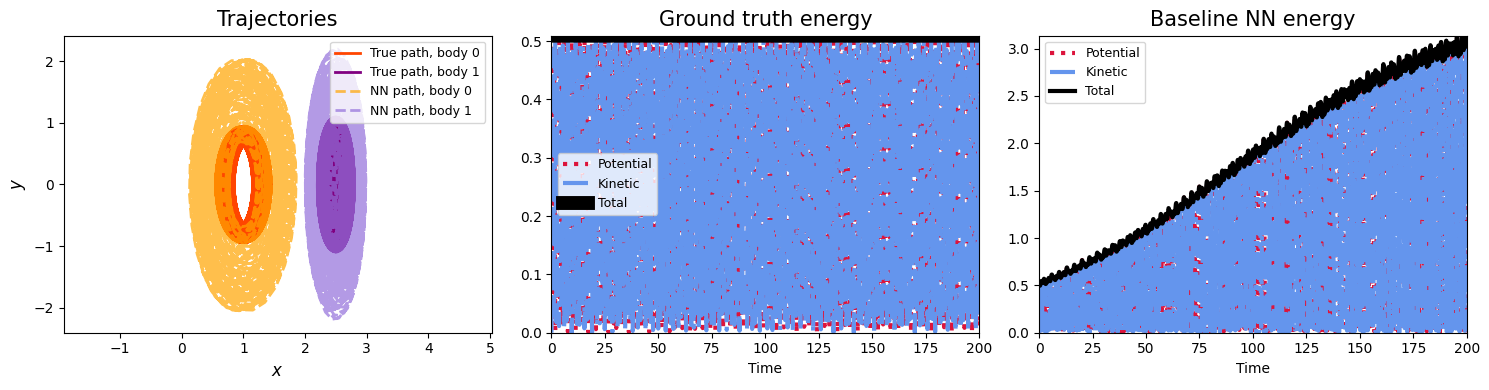

In [15]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(base_pe)], base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(base_ke)], base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(base_etot)], base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()


In [16]:
# Using the same y0 as baseline
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

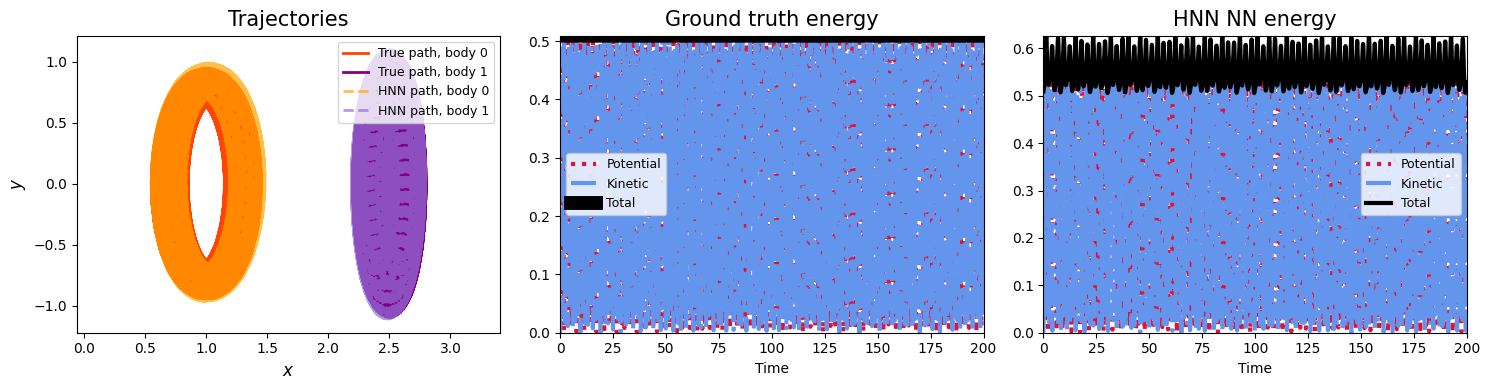

In [17]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7,label='HNN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(hnn_pe)], hnn_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(hnn_ke)], hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(hnn_etot)], hnn_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()


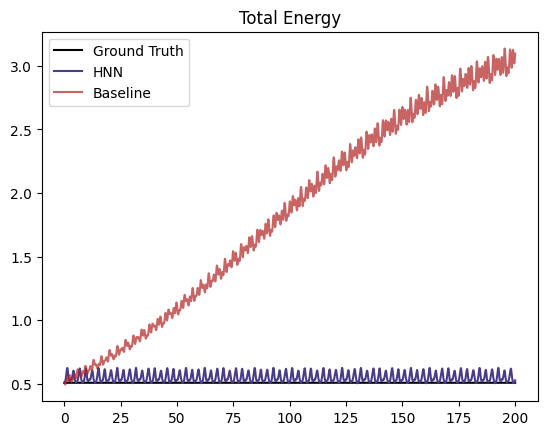

In [18]:
#Energy plot
plt.plot(t[:len(real_etot)], real_etot,'-k', label='Ground Truth')
plt.plot(t[:len(hnn_etot)], hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t[:len(base_etot)], base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

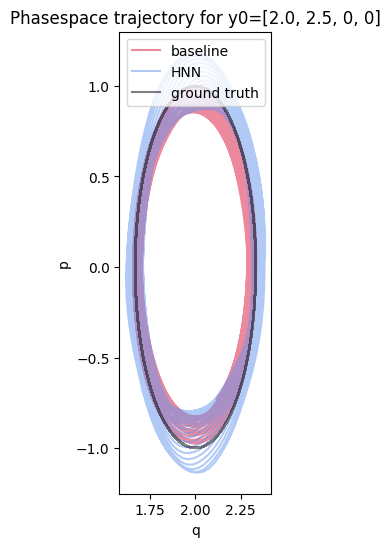

In [19]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))


plt.show()

## Train with 0.05 noise

In [49]:
!python experiment-3spring/train_collision.py --verbose --input_noise=0.05
!python experiment-3spring/train_collision.py --baseline --verbose --input_noise=0.05

Training HNN model:
step 0, train_loss 2.9481e+00, test_loss 3.0641e+00, grad norm 2.4045e-02, grad std 7.6026e-04
step 200, train_loss 7.9518e-02, test_loss 7.5397e-02, grad norm 5.0220e-01, grad std 3.4745e-03
step 400, train_loss 6.3007e-02, test_loss 8.1243e-02, grad norm 1.4612e-01, grad std 1.8741e-03
step 600, train_loss 6.2433e-02, test_loss 6.3688e-02, grad norm 4.0532e-01, grad std 3.1214e-03
step 800, train_loss 4.9736e-02, test_loss 6.7022e-02, grad norm 4.6361e-01, grad std 3.3383e-03
step 1000, train_loss 5.6629e-02, test_loss 6.3425e-02, grad norm 1.5449e-02, grad std 6.0941e-04
Final train loss 5.7079e-02 +/- 2.3880e-03
Final test loss 6.0532e-02 +/- 2.6816e-03
Training baseline model:
step 0, train_loss 3.7213e+00, test_loss 3.9064e+00, grad norm 1.2895e+01, grad std 1.7523e-02
step 200, train_loss 7.2692e-02, test_loss 7.1687e-02, grad norm 4.1440e-01, grad std 3.1412e-03
step 400, train_loss 7.9113e-02, test_loss 6.6049e-02, grad norm 7.7748e+00, grad std 1.3606e-02


In [50]:
y0 = get_rand_starting_position()

q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

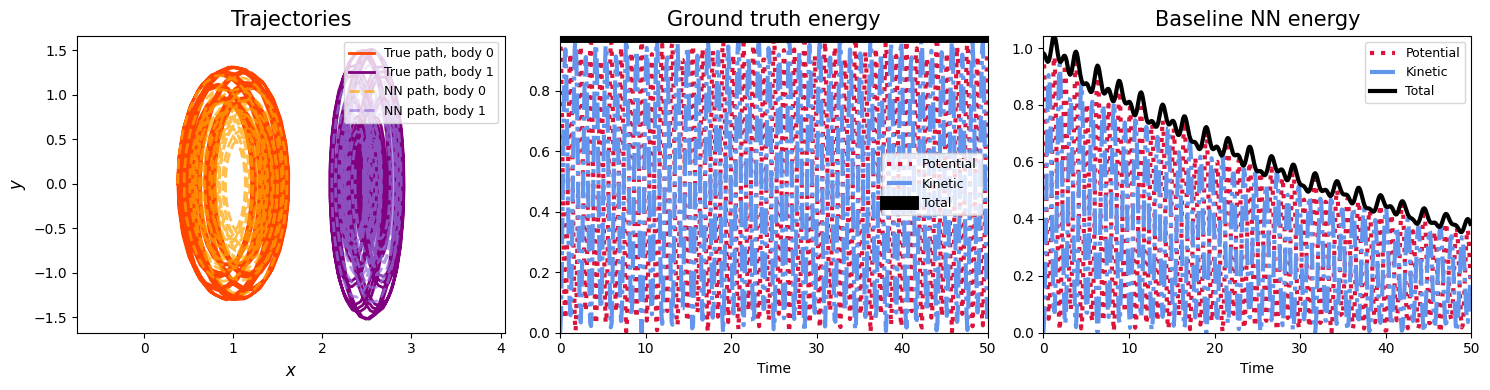

In [51]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(base_pe)], base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(base_ke)], base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(base_etot)], base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()


In [52]:
# Using the same y0 as baseline
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

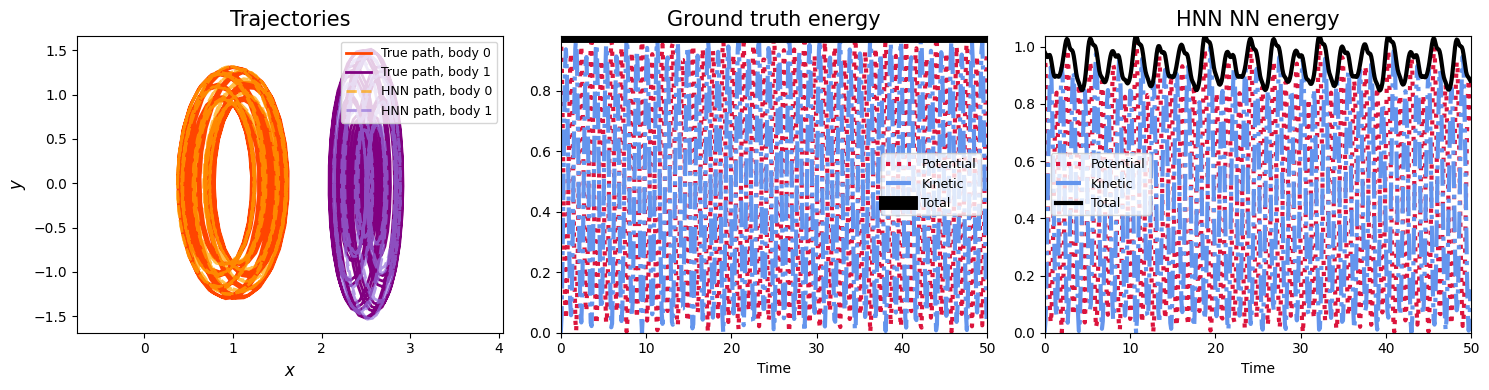

In [53]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7,label='HNN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(hnn_pe)], hnn_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(hnn_ke)], hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(hnn_etot)], hnn_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()


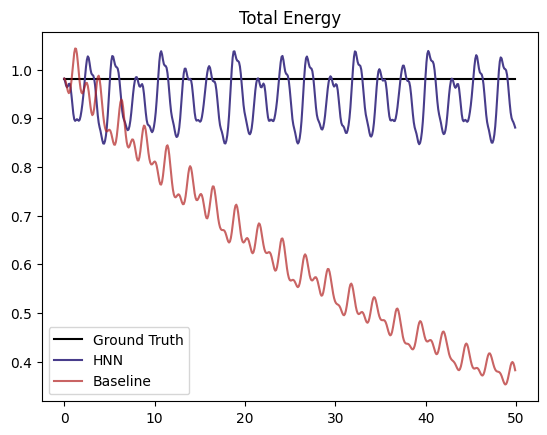

In [54]:
#Energy plot
plt.plot(t[:len(real_etot)], real_etot,'-k', label='Ground Truth')
plt.plot(t[:len(hnn_etot)], hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t[:len(base_etot)], base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

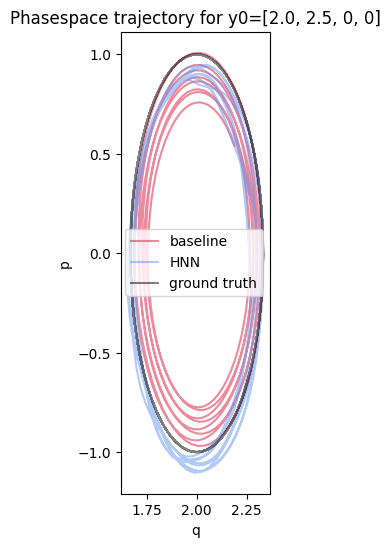

In [55]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))


plt.show()

## Train with 0.1 noise

In [56]:
!python experiment-3spring/train_collision.py --verbose --input_noise=0.1
!python experiment-3spring/train_collision.py --baseline --verbose --input_noise=0.1

Training HNN model:
step 0, train_loss 3.6000e+00, test_loss 4.2471e+00, grad norm 8.6409e-02, grad std 1.4412e-03
step 200, train_loss 2.7286e-01, test_loss 2.2301e-01, grad norm 1.4480e+00, grad std 5.8995e-03
step 400, train_loss 2.1908e-01, test_loss 2.2185e-01, grad norm 5.3985e-01, grad std 3.6021e-03
step 600, train_loss 2.2084e-01, test_loss 1.9855e-01, grad norm 3.9580e-01, grad std 3.0845e-03
step 800, train_loss 2.0785e-01, test_loss 2.3724e-01, grad norm 3.3349e+00, grad std 8.9530e-03
step 1000, train_loss 2.1331e-01, test_loss 2.3197e-01, grad norm 1.9080e+00, grad std 6.7723e-03
Final train loss 2.0400e-01 +/- 9.5742e-03
Final test loss 2.2368e-01 +/- 1.0134e-02
Training baseline model:
step 0, train_loss 4.0126e+00, test_loss 5.7909e+00, grad norm 6.1692e+00, grad std 1.2120e-02
step 200, train_loss 2.0791e-01, test_loss 2.2895e-01, grad norm 1.7518e-01, grad std 2.0423e-03
step 400, train_loss 2.2314e-01, test_loss 2.2571e-01, grad norm 1.0932e+00, grad std 5.1019e-03


In [57]:
y0 = get_rand_starting_position()

q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

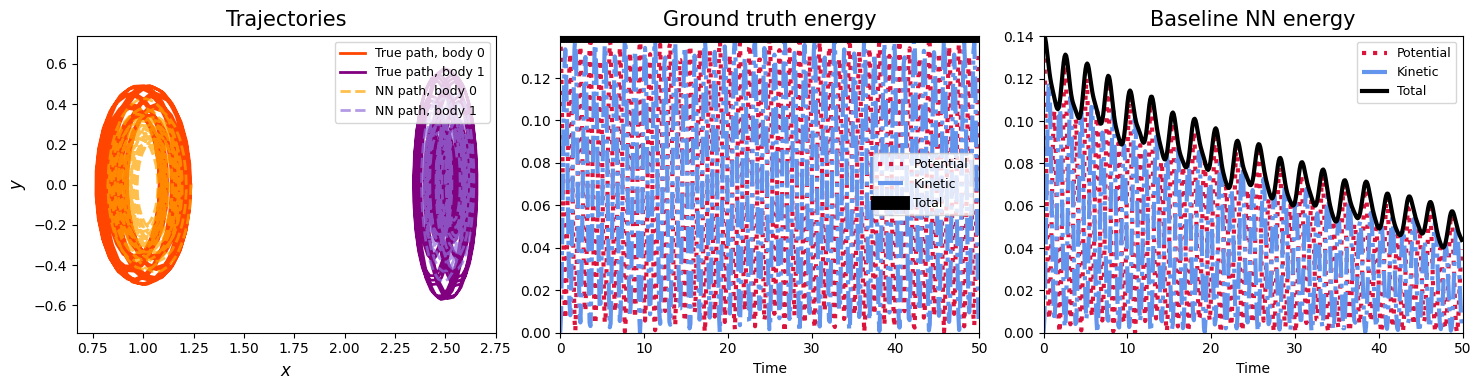

In [58]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(base_pe)], base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(base_ke)], base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(base_etot)], base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()


In [59]:
# Using the same y0 as baseline
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

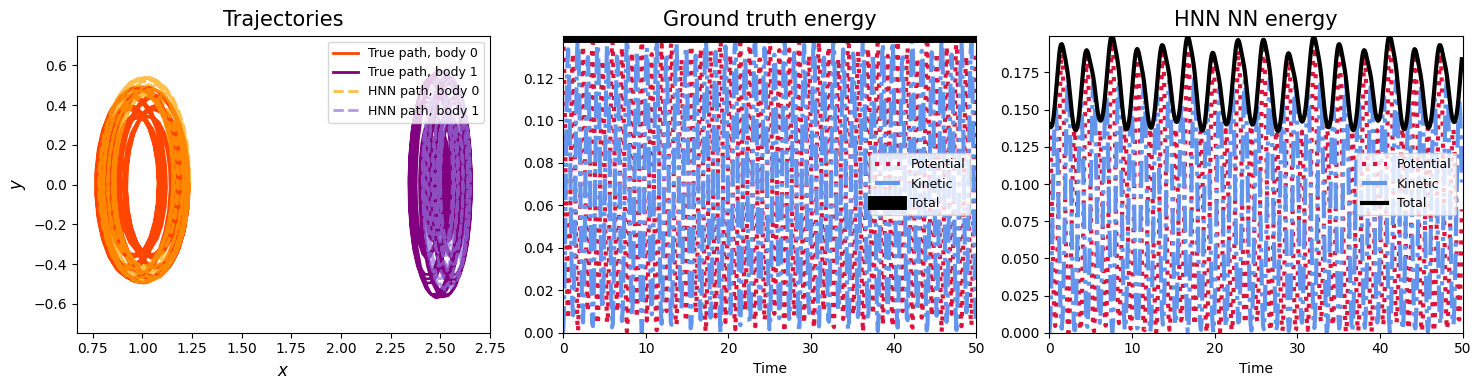

In [60]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7,label='HNN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(hnn_pe)], hnn_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(hnn_ke)], hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(hnn_etot)], hnn_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()


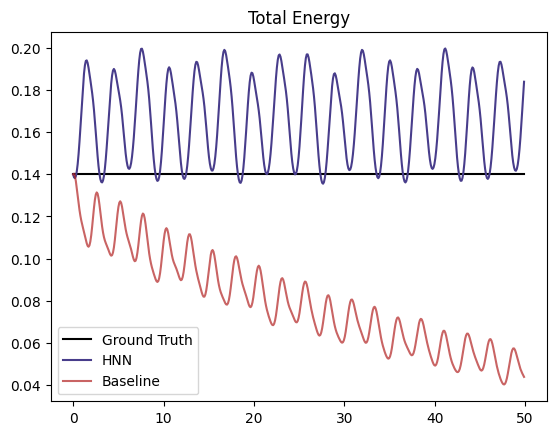

In [61]:
#Energy plot
plt.plot(t[:len(real_etot)], real_etot,'-k', label='Ground Truth')
plt.plot(t[:len(hnn_etot)], hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t[:len(base_etot)], base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

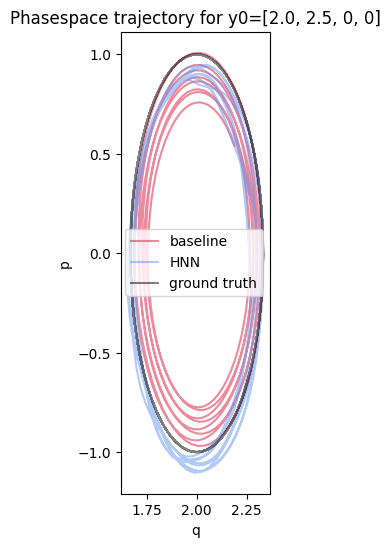

In [62]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))


plt.show()

# If in the previous examples we did not have collision then run this part

In [24]:
y0 = [l1+l2, l1+l2, 0.0, 0.0]

q, p, dq, dp, t, settings = get_trajectory(t_span=t_span, t_points=t_points, y0=y0, radius=0.7, noise_std = 0)

update_fn = lambda t, y0: model_update(t, y0, base_model)
q_base, p_base, dq_base, dp_base, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

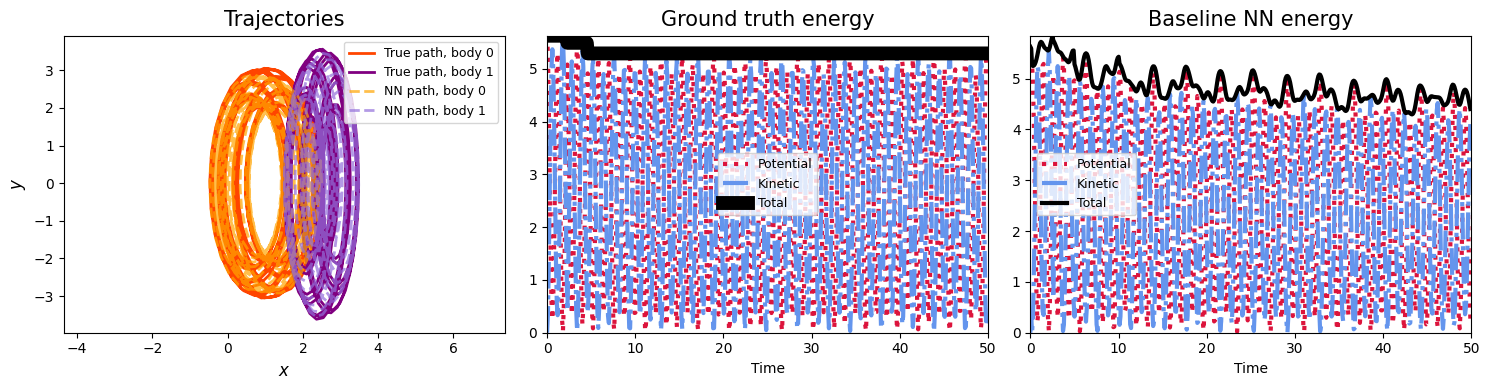

In [25]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_base[:,i], p_base[:,i], '--', c=colors[i+2], alpha=0.7,label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
base_pe, base_ke  = potential_energy(q_base, args=get_args_ham()), kinetic_energy(p_base, args=get_args_ham())
base_etot = base_pe + base_ke

plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(base_pe)], base_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(base_ke)], base_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(base_etot)], base_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
base_ymin = np.min([base_pe.min(), base_ke.min(), base_etot.min()])
base_ymax = np.max([base_pe.max(), base_ke.max(), base_etot.max()])
plt.ylim(base_ymin, base_ymax)

plt.tight_layout() ; plt.show()


In [26]:
# Using the same y0 as baseline
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
q_hnn, p_hnn, dq_hnn, dp_hnn, t, settings = get_trajectory(y0=y0, t_points=t_points, t_span=t_span, update_fn=update_fn, noise_std=0)

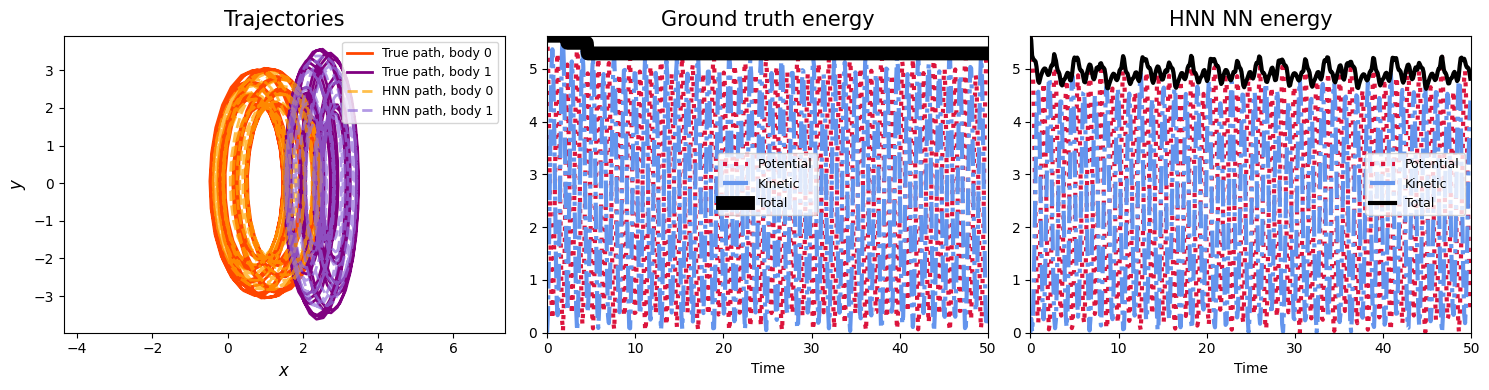

In [27]:
fig = plt.figure(figsize=fig_size, dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
for i in range(2):
    plt.plot(q[:,i], p[:,i], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i in range(2):
    plt.plot(q_hnn[:,i], p_hnn[:,i], '--', c=colors[i+2], alpha=0.7,label='HNN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs, loc="upper right")

plt.subplot(1,3,2)
real_pe, real_ke  = potential_energy(q, args=get_args_ham()), kinetic_energy(p, args=get_args_ham())
real_etot = real_pe + real_ke
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(real_pe)], real_pe, ':', color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(real_ke)], real_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(real_etot)], real_etot, 'k-', label='Total', linewidth=10)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
hnn_pe, hnn_ke  = potential_energy(q_hnn, args=get_args_ham()), kinetic_energy(p_hnn, args=get_args_ham())
hnn_etot = hnn_pe + hnn_ke

plt.title('HNN NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(t[:len(hnn_pe)], hnn_pe, ':',color='crimson', label='Potential', linewidth=lw)
plt.plot(t[:len(hnn_ke)], hnn_ke, '-.', color='cornflowerblue', label='Kinetic', linewidth=lw)
plt.plot(t[:len(hnn_etot)], hnn_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
hnn_ymin = np.min([hnn_pe.min(), hnn_ke.min(), hnn_etot.min()])
hnn_ymax = np.max([hnn_pe.max(), hnn_ke.max(), hnn_etot.max()])
plt.ylim(hnn_ymin, hnn_ymax)

plt.tight_layout() ; plt.show()


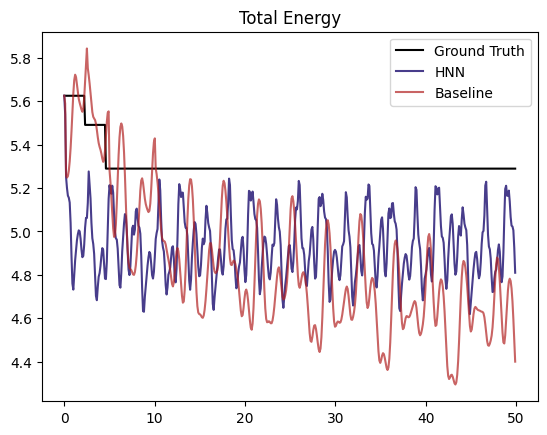

In [28]:
#Energy plot
plt.plot(t[:len(real_etot)], real_etot,'-k', label='Ground Truth')
plt.plot(t[:len(hnn_etot)], hnn_etot,'-', label='HNN', color='darkslateblue')
plt.plot(t[:len(base_etot)], base_etot,'-', label='Baseline', color='firebrick', alpha=0.7)
plt.title("Total Energy")
plt.legend()
plt.show()

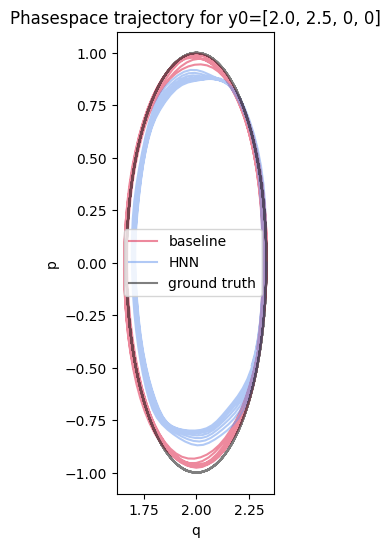

In [29]:
y0_cm =[args_ham['l1']+1,args_ham['l2']+1,0,0]
q_cm, p_cm, dq_cm, dp_cm, t_cm, settings_cm = get_trajectory(t_span=t_span, t_points=t_points, y0=y0_cm, noise_std = 0)
q_center= (q_cm[:,0]*args_ham['m1']+q_cm[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center= (p_cm[:,0]+p_cm[:,1])


update_fn_base = lambda t, y0: model_update(t, y0, base_model)
q_cm_base, p_cm_base, dq_cm_base, dp_cm_base, t_cm_base, settings_cm_base = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_base, noise_std=0)
q_center_base= (q_cm_base[:,0]*args_ham['m1']+q_cm_base[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_base= (p_cm_base[:,0]+p_cm_base[:,1])


update_fn_hnn = lambda t, y0: model_update(t, y0, hnn_model)
q_cm_hnn, p_cm_hnn, dq_cm_hnn, dp_cm_hnn, t_cm_hnn, settings_cm_hnn = get_trajectory(y0=y0_cm, t_points=t_points, t_span=t_span, update_fn=update_fn_hnn, noise_std=0)
q_center_hnn= (q_cm_hnn[:,0]*args_ham['m1']+q_cm_hnn[:,1]*args_ham['m2'])/(args_ham['m1']+args_ham['m2'])
p_center_hnn= (p_cm_hnn[:,0]+p_cm_hnn[:,1])

fig, ax1 = plt.subplots(1,1,figsize=(4,6))
t_points = 50
t_span = [0,50]

ax1.plot(q_center_base, p_center_base, color='crimson', alpha=0.5, label='baseline')
ax1.plot(q_center_hnn, p_center_hnn,color='cornflowerblue', alpha=0.5, label='HNN')
ax1.plot(q_center, p_center,  color='black', alpha=0.5, label='ground truth')
ax1.legend()

ax1.autoscale()
ax1.set_aspect('equal')
ax1.set_xlabel('q')
ax1.set_ylabel('p')
ax1.set_title('Phasespace trajectory for y0={}'.format(y0_cm))


plt.show()